## Modules

In [1]:
# Modules
import sys
sys.path.append("/home/simon/Documents/REPO/Exact_laws")
sys.path.append("/home/simon/Documents/REPO/Simu/Rapport_simu_exactlaw/notebook")

from exact_laws.preprocessing.process_on_standard_h5_file import describ_file
from visualisation_tools import *
from exact_laws.mathematical_tools.derivation import cdiff

import os
from matplotlib import ticker, rc
import numpy as np
import json

In [22]:
# Matplotlib config
#%matplotlib widget
%matplotlib qt5
plt.rcParams['text.usetex'] = True
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('font', size=18)

numfig = 0

## Informations et données

In [7]:
simu_name = 'CGL3'
with open("/home/simon/Documents/REPO/Simu/descript_oca_simu.json","r") as f:
    simus = json.load(f)[simu_name]
times = list(simus.keys())
for t in times : 
    if not '362' in t: del(simus[t])
times = list(simus.keys())
simus_name= 'CGL3.362'
print(simus[times[0]])

{'original_folder': '/home/simon/Documents/DATA/SIMULATIONS/OCA/data_simus_oca/CGL3/CGL3_361-362/', 'cycle': 'cycle_1', 'group_grid': '3Dgrid', 'N': [512, 512, 1024], 'kdi': 0.5, 'theta': 1.3090102816940696, 'thrsh_forc_hi': 0.045, 'thrsh_forc_lo': 0.0422, 'a1_forc': 0.5, 'act_forc': True, 'nu': 4e-14, 'eta': 4e-14, 'hdiss_rho': 1.6e-14, 'hdiss_p': 1.6e-14, 'an_hd': 2, 'ap0': 1, 'B0': [0, 0, 1], 'beta0': 1, 'name': 'CGL3.362', 'EL_2D': '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL3.362/OCA_CGL3.362_alltf_EL_lincart_all_red2D.h5'}


In [8]:
# Paths 
path_record_images = f"./images_{simu_name}/"
if not os.path.exists(path_record_images) : os.mkdir(path_record_images)

In [9]:
# Paramètres
simu = f"{simu_name}"
kdi = simus[times[0]]['kdi'] # kperpdi = 2pidi/l => l/di = 2pi/(kdi)
theta = simus[times[0]]['theta']
lforc = np.array([(2*np.pi/kdi, 2*np.pi/kdi*np.tan(theta)),(2*np.pi/kdi/np.sqrt(2), 2*np.pi/kdi*np.tan(theta))]) # (lperp/di, lpar/di)
linert = (1,1)
print(lforc)

[[12.56637061 46.90083673]
 [ 8.88576588 46.90083673]]


In [10]:
# Grille
grid = read_grid_in_h5file(simus[times[0]]['EL_2D'])
c = grid['c']
print(c)
axe_par = np.array(grid['lpar'])*grid['c'][2]
axe_perp = np.array(grid['lperp'])*grid['c'][0]
label_par = "$\ell_{\parallel} / d_i$"
label_perp = "$\ell_{\perp}/ d_i$"
del(grid)
grid = read_grid_in_h5file(simus[times[0]]['EL_red1D'][0])
axe_l = np.array(grid['l'])
label_l = "$\ell / d_i$"
print(axe_par[1],axe_par[2],max(axe_par))
print(axe_perp[1],axe_perp[2],max(axe_perp))
print(axe_l[1],max(axe_l))

[0.02454369 0.02454369 0.0458016 ]


KeyError: 'EL_red1D'

In [11]:
gridlp, gridlpar = np.meshgrid(axe_perp,axe_par, indexing='ij')
filt_45 = np.arctan(gridlpar/np.where(gridlp==0,1e-19,gridlp))*180/np.pi
filt_45inf = np.where(filt_45<=45,1,np.nan)
filt_45sup = np.where(filt_45>=45,1,np.nan)
filt_45b = np.arctan(gridlpar/np.where(gridlp==0,1e-19,gridlp))
filt_45binf = np.where(filt_45b<=theta,1,np.nan)
filt_45bsup = np.where(filt_45b>=theta,1,np.nan)
filt_45c = np.arctan(gridlpar/c[2]/np.where(gridlp==0,1e-19,gridlp)*c[1])*180/np.pi
filt_45cinf = np.where(filt_45c<=45,1,np.nan)
filt_45csup = np.where(filt_45c>=45,1,np.nan)
filt_perp10pc = np.where(gridlp<=lforc[1,0]*0.1,1,np.nan)
filt_par10pc = np.where(gridlpar<=lforc[1,1]*0.1,1,np.nan)
del(gridlp,gridlpar)

In [12]:
# liste des temps
dict_temps = {}
for t in times : 
    if '_R' in t : 
        dict_temps[t] = eval(t[:-2])
    else : 
        dict_temps[t] = eval(t)
temps =  sorted(dict_temps.items(), key=lambda t: t[1])
dt = temps[1][1] - temps[0][1]

IndexError: list index out of range

## Lecture et assemblage de lois exactes

In [13]:
# Lecture fichiers et corrections
dict_quantities = {}
dict_quantities1D = {}
dict_coeffs = {}
quantities = {} 
quantities1D = {}  
coeffs = {}

for it,t in enumerate(simus.keys()):
    dict_quantities[t] = {}
    dict_coeffs[t] = {}
    for fstr in simus[t]['EL_red2D']:
        dqs, _, dcs = readfile(fstr)
        for k in dqs.keys():
            dict_quantities[t][k] = dqs[k] 
        for k in dcs.keys():
            dict_coeffs[t][k] = dcs[k]
            if "source_rbdd" in k:
                dict_coeffs[t][k] = -np.abs(dcs[k])
            if "ue" in k :
                dict_coeffs[t][k] = -np.abs(dcs[k])*1836
    dict_coeffs[t]['COR_dt_cor_rvv'] = 1
    dict_coeffs[t]['COR_dt_cor_rbb'] = 1
    dict_coeffs[t]['COR_dt_cor_ru'] = 1
    dict_coeffs[t]['ICOR_dt_cor_vv'] = 1
    dict_coeffs[t]['ICOR_dt_cor_bb'] = 1
    
    dict_quantities1D[t] = {}
    for fstr in simus[t]['EL_red1D']:
        dqs, _, dcs = readfile(fstr)
        for k in dqs.keys():
            dict_quantities1D[t][k] = dqs[k] 
for q in dict_quantities[times[-1]].keys():
    quantities[q] = np.mean(np.array([dict_quantities[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_quantities1D[times[-1]].keys():
    quantities1D[q] = np.mean(np.array([dict_quantities1D[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_coeffs[times[-1]].keys():
    coeffs[q] = dict_coeffs[times[-1]][q]


KeyError: 'EL_red2D'

In [11]:
# dt des quantitées
quantities_name = [k for k in quantities if k.startswith('cor_')]
for q in quantities_name:
    tab = []
    for t in temps: 
        tab.append(dict_quantities[t[0]][q])
    dt_tab = cdiff(tab, length_case=dt, dirr=0, precision=2, period=False, point=False)
    for i in range(len(temps)):
        dict_quantities[temps[i][0]]['dt_'+q] = dt_tab[i]
    quantities['dt_'+q] = np.mean(dt_tab[1:-1],axis=0)

# dt des quantitées
quantities_name = [k for k in quantities1D if k.startswith('cor_')]
for q in quantities_name:
    tab = []
    for t in temps: 
        tab.append(dict_quantities1D[t[0]][q])
    dt_tab = cdiff(tab, length_case=dt, dirr=0, precision=2, period=False, point=False)
    if q == 'cor_rvv': print(dt_tab[0][0],dt_tab[1][0],dt_tab[1][0])
    for i in range(len(temps)):
        dict_quantities1D[temps[i][0]]['dt_'+q] = dt_tab[i]
    quantities1D['dt_'+q] = np.mean(dt_tab,axis=0)

-0.0006605466863023036 -0.0006613811848576031 -0.0006613811848576031


In [17]:
# Combinaisons de termes
dic_of_list_terms = {}
dic_of_list_terms['PP98'] = [k for k in coeffs if k.startswith('PP98_')]
dic_of_list_terms['BG17'] = [k for k in coeffs if k.startswith('BG17_')]
dic_of_list_terms['IHcorr'] = [k for k in coeffs if k.startswith('IHallcor_')]
dic_of_list_terms['F19'] = [k for k in coeffs if (k.startswith('PP98_') or k.startswith('IHallcor_'))]
dic_of_list_terms['BG17H'] = [k for k in coeffs if (k.startswith('BG17_') or k.startswith('IHallcor_'))]
dic_of_list_terms

{'PP98': ['PP98_div_flux_dbdbdv',
  'PP98_div_flux_dvdbdb',
  'PP98_div_flux_dvdvdv'],
 'BG17': ['BG17_bg17_jbv', 'BG17_bg17_vbj', 'BG17_bg17_vwv'],
 'IHcorr': ['IHallcor_div_flux_dbdbdj', 'IHallcor_div_flux_djdbdb'],
 'F19': ['IHallcor_div_flux_dbdbdj',
  'IHallcor_div_flux_djdbdb',
  'PP98_div_flux_dbdbdv',
  'PP98_div_flux_dvdbdb',
  'PP98_div_flux_dvdvdv'],
 'BG17H': ['BG17_bg17_jbv',
  'BG17_bg17_vbj',
  'BG17_bg17_vwv',
  'IHallcor_div_flux_dbdbdj',
  'IHallcor_div_flux_djdbdb']}

In [23]:
yPP98 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['PP98'])
yF19 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['F19'])
yHall = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['IHcorr'])
yBG17 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['BG17'])

In [20]:
PP98_ref = np.loadtxt("/home/simon/Documents/REPO/memory/images/Part_3/valid_inc/CGL3_PP98_ferrand_2021.txt",)
F19_ref = np.loadtxt("/home/simon/Documents/REPO/memory/images/Part_3/valid_inc/CGL3_F19_ferrand_2021.txt",)
Hall_ref = np.loadtxt("/home/simon/Documents/REPO/memory/images/Part_3/valid_inc/CGL3_Hallinc_ferrand_2021.txt",)

In [46]:
plt.figure('M2', figsize=(8,4))
plt.clf()
l1,_ = splot(axe_perp[1:],np.nanmean(yF19*filt_45cinf,axis=1)[1:],label = '$\\varepsilon_{F19}$') #np.nanmean(yF19*filt_45inf,axis=1)[1:]
plt.plot(F19_ref[:,0],F19_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{F19}$') 
l1,_ = splot(axe_perp[1:],np.nanmean(yPP98*filt_45cinf,axis=1)[1:],label = '$\\varepsilon_{PP98}$') #np.nanmean(yPP98*filt_45inf,axis=1)[1:]
plt.plot(PP98_ref[:,0],PP98_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{PP98}$') 
l1,_ = splot(axe_perp[1:],np.nanmean(yHall*filt_45cinf,axis=1)[1:],label = '$\\varepsilon_{Hall}$') #np.nanmean(yHall*filt_45inf,axis=1)[1:]
l1,_ = splot(axe_perp[1:],yF19[1:,0],label = '$\\varepsilon_{F19}$') #np.nanmean(yF19*filt_45inf,axis=1)[1:]
#plt.plot(F19_ref[:,0],F19_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{F19}$') 
l1,_ = splot(axe_perp[1:],yPP98[1:,0],label = '$\\varepsilon_{PP98}$') #np.nanmean(yPP98*filt_45inf,axis=1)[1:]
#plt.plot(PP98_ref[:,0],PP98_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{PP98}$') 
l1,_ = splot(axe_perp[1:],yHall[1:,0],label = '$\\varepsilon_{Hall}$') #np.nanmean(yHall*filt_45inf,axis=1)[1:]
#plt.plot(Hall_ref[:,0],Hall_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{Hall}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8,1e-3)
plt.ylabel('CGL3')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

In [21]:
plt.figure('M3', figsize=(8,4))
plt.clf()
l1,_ = splot(axe_par[1:],np.nanmean(yF19*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{F19}$') 
l1,_ = splot(axe_par[1:],np.nanmean(yBG17*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{BG17}$') 
l1,_ = splot(axe_par[1:],np.nanmean(yF19*filt_45csup-yBG17*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{F19} - \\varepsilon_{BG17}$') 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7,1e-3)
plt.ylabel('$\\varepsilon_{PP98}$')
plt.xlabel('$\ell_{\\parallel}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

/tmp/ipykernel_310859/3371781236.py:3: RuntimeWarning: Mean of empty slice
  l1,_ = splot(axe_par[1:],np.nanmean(yF19*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{F19}$')
/tmp/ipykernel_310859/3371781236.py:4: RuntimeWarning: Mean of empty slice
  l1,_ = splot(axe_par[1:],np.nanmean(yBG17*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{BG17}$')
/tmp/ipykernel_310859/3371781236.py:5: RuntimeWarning: Mean of empty slice
  l1,_ = splot(axe_par[1:],np.nanmean(yF19*filt_45csup-yBG17*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{F19} - \\varepsilon_{BG17}$')


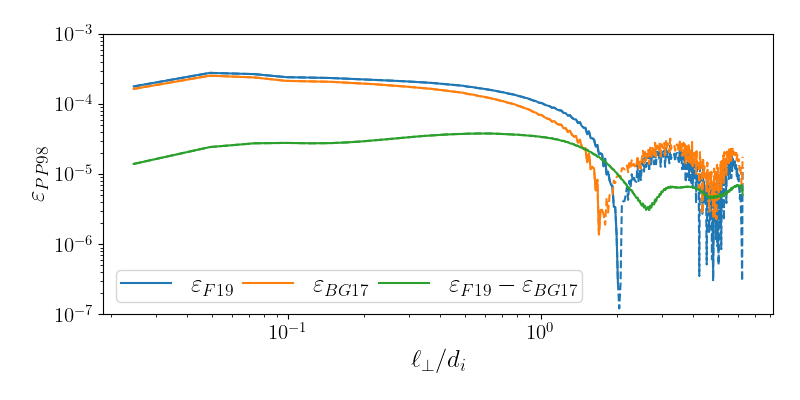

In [54]:
plt.figure('M4', figsize=(8,4))
plt.clf()
l1,_ = splot(axe_perp[1:],np.nanmean(yF19*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{F19}$') 
l1,_ = splot(axe_perp[1:],np.nanmean(yBG17*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{BG17}$') 
l1,_ = splot(axe_perp[1:],np.nanmean(yF19*filt_45binf-yBG17*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{F19} - \\varepsilon_{BG17}$') 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7,1e-3)
plt.ylabel('$\\varepsilon_{PP98}$')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

In [125]:
from matplotlib import gridspec
X,Y = np.meshgrid(axe_perp,axe_par)
Z = yPP98_Fx[0]*np.sin(theta)+yPP98_Fx[1]*np.cos(theta) #dict_yPP98['362']
Z2 = yPP98_Fx[2]
fig = plt.figure('M5', figsize=(10,10))
plt.clf()

#fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 2],'height_ratios': [2, 1]})
spec = gridspec.GridSpec(ncols=3, nrows=2,
                         width_ratios=[1, 2,0.5], wspace=0,
                         hspace=0, height_ratios=[2, 1])


ax1 = plt.subplot(spec[1])
ax1.set_title('CGL3')
colormap = ax1.pcolor(X,Y,np.transpose(Z), norm=colors.SymLogNorm(linthresh = 1e-6, vmin = - np.max(np.abs(Z)), vmax=np.max(np.abs(Z))),
                   cmap='Spectral_r', shading='auto')

contours = ax1.contour(X,Y,np.transpose(Z),10,cmap='Spectral',vmin = - np.max(Z), vmax=np.max(Z))
#plt.clabel(contours, inline=False, fontsize=15,rightside_up=True,use_clabeltext =True,
           #manual=[(1,413),(1,320),(1,240),(1,167),(1,67),(0.5,12)])#fmt='%.1E',inline_spacing=1,

ax1.plot(axe_perp[1:],axe_perp[1:]*np.tan(theta),'k-.',label='$\\theta = \\theta_i$')
ax1.plot(axe_perp[1:],axe_perp[1:]*np.tan(45*np.pi/180),'k-.',label='$\\theta = \\theta_i$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(axe_perp[1],axe_perp[-1])
ax1.set_ylim(axe_par[1],axe_par[-1])

ax0 = plt.subplot(spec[0],sharey=ax1)
subsplot(ax0,axe_par[1:],np.nanmean(yPP98*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98}$',orientation = 'inverse') 
#subsplot(ax0,axe_par[1:],np.nanmean(yBG17*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{BG17}$',orientation = 'inverse') 
subsplot(ax0,axe_par[1:],np.nanmean(Z*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse') 
subsplot(ax0,axe_par[1:],np.nanmean(Z*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse') 
subsplot(ax0,axe_par[1:],np.nanmean(Z2*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse') 
subsplot(ax0,axe_par[1:],np.nanmean(Z2*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse') 
ax0.plot([2,4],[4,5],'k-.',label='$\\theta = \\theta_i$')

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(1e-7,9e-4)
#ax0.set_ylabel('$\\varepsilon_{PP98}$')
ax0.set_ylabel('$\ell_{\\parallel}/d_i$')
#plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
ax0.set_xticks([1e-7,1e-6,1e-5,1e-4])

ax4 = plt.subplot(spec[4],sharex=ax1)
subsplot(ax4,axe_perp[1:],np.nanmean(yPP98*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{PP98}$') 
#subsplot(ax4,axe_perp[1:],np.nanmean(Z*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$') 
#subsplot(ax4,axe_perp[1:],np.nanmean(Z*filt_45cinf,axis=1)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$') 
#subsplot(ax4,axe_perp[1:],np.nanmean(Z2*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$') 
#subsplot(ax4,axe_perp[1:],np.nanmean(Z2*filt_45cinf,axis=1)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$') 
div = (np.nanmean(Z*filt_45cinf,axis=1)[2:]*axe_perp[2:]-np.nanmean(Z*filt_45cinf,axis=1)[:-2]*axe_perp[:-2])/axe_perp[1]/axe_perp[1:-1]/2
subsplot(ax4,axe_perp[1:-1],div,label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$')
div = (np.nanmean(Z*filt_45binf,axis=1)[2:]*axe_perp[2:]-np.nanmean(Z*filt_45binf,axis=1)[:-2]*axe_perp[:-2])/axe_perp[1]/axe_perp[1:-1]/2
subsplot(ax4,axe_perp[1:-1],div,label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$')

#div = (np.nanmean(Z,axis=1)[1:]*axe_perp[1:]-np.nanmean(Z,axis=1)[0:-1]*axe_perp[:-1])/axe_perp[1]/axe_perp[1:]
#subsplot(ax4,axe_perp[1:],div,label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$')  
ax4.plot(PP98_ref[:,0],PP98_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{PP98}$') 
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_ylim(1e-7,9e-4)
#plt.ylabel('$\\varepsilon_{PP98}$')
ax4.set_xlabel('$\ell_{\\perp}/d_i$')
#plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)

ax2 = plt.subplot(spec[2])
ax2.axis('off')

# ax5 = plt.subplot(spec[5])
# ax5.axis('off')
cbar = fig.colorbar(contours,ax = [ax2,],location='left',anchor=(0.7,0),pad=0.5, fraction=1,) #
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar2 = fig.colorbar(colormap,ax = [ax2,],location='right',label='$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',anchor=(-0.1,0), fraction=1) #

ax0.legend(bbox_to_anchor=(4.2, -0.1))
# plt.xlim(axe_perp[1],axe_perp[-1])
# plt.ylim(axe_par[1],axe_par[-1])
# plt.ylabel('$\ell_{\\parallel}/d_i$')
# plt.xlabel('$\ell_{\\perp}/d_i$')
#plt.legend(framealpha=0.6,labelspacing=0.2,borderpad=0.2)
#plt.tight_layout()
plt.show()

/tmp/ipykernel_310859/1289234392.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()
/tmp/ipykernel_310859/1289234392.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()
/tmp/ipykernel_310859/1289234392.py:31: RuntimeWarning: Mean of empty slice
  subsplot(ax0,axe_par[1:],np.nanmean(yPP98*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98}$',orientation = 'inverse')
/tmp/ipykernel_310859/1289234392.py:33: RuntimeWarning: Mean of empty slice
  subsplot(ax0,axe_par[1:],np.nanmean(Z*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse')
/tmp/ipykernel_310859/1289234392.py:34: RuntimeWarning: Mean of empty slice
  subsplot(ax0,axe_par[1:],np.nanmean(Z*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse')
/tmp/ipykernel_310859/1289234392.py:35: Runti

In [129]:
from matplotlib import gridspec
X,Y = np.meshgrid(axe_perp,axe_par)
Z = yPP98_Fx[0]*np.sin(theta)+yPP98_Fx[1]*np.cos(theta) #dict_yPP98['362']
Z2 = yPP98_Fx[2]
fig = plt.figure('M5', figsize=(10,10))
plt.clf()

#fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 2],'height_ratios': [2, 1]})
spec = gridspec.GridSpec(ncols=3, nrows=2,
                         width_ratios=[1, 2,0.5], wspace=0,
                         hspace=0, height_ratios=[2, 1])


ax1 = plt.subplot(spec[1])
ax1.set_title('CGL3')
colormap = ax1.pcolor(X,Y,np.transpose(Z), norm=colors.SymLogNorm(linthresh = 1e-6, vmin = - np.max(np.abs(Z)), vmax=np.max(np.abs(Z))),
                   cmap='Spectral_r', shading='auto')

contours = ax1.contour(X,Y,np.transpose(Z),10,cmap='Spectral',vmin = - np.max(Z), vmax=np.max(Z))
#plt.clabel(contours, inline=False, fontsize=15,rightside_up=True,use_clabeltext =True,
           #manual=[(1,413),(1,320),(1,240),(1,167),(1,67),(0.5,12)])#fmt='%.1E',inline_spacing=1,

ax1.plot(axe_perp[1:],axe_perp[1:]*np.tan(theta),'k-.',label='$\\theta = \\theta_i$')
ax1.plot(axe_perp[1:],axe_perp[1:]*np.tan(45*np.pi/180),'k-.',label='$\\theta = \\theta_i$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(axe_perp[1],axe_perp[-1])
ax1.set_ylim(axe_par[1],axe_par[-1])

ax0 = plt.subplot(spec[0],sharey=ax1)
subsplot(ax0,axe_par[1:],np.nanmean(yPP98*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98}$',orientation = 'inverse') 
#subsplot(ax0,axe_par[1:],np.nanmean(yBG17*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{BG17}$',orientation = 'inverse') 
subsplot(ax0,axe_par[1:],np.nanmean(Z*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse') 
subsplot(ax0,axe_par[1:],np.nanmean(Z*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse') 
subsplot(ax0,axe_par[1:],np.nanmean(Z2*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse') 
subsplot(ax0,axe_par[1:],np.nanmean(Z2*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse') 
ax0.plot([2,4],[4,5],'k-.',label='$\\theta = \\theta_i$')

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(1e-7,9e-4)
#ax0.set_ylabel('$\\varepsilon_{PP98}$')
ax0.set_ylabel('$\ell_{\\parallel}/d_i$')
#plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
ax0.set_xticks([1e-7,1e-6,1e-5,1e-4])

ax4 = plt.subplot(spec[4],sharex=ax1)
subsplot(ax4,axe_perp[1:],np.nanmean(yPP98*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{PP98}$') 
#subsplot(ax4,axe_perp[1:],np.nanmean(Z*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$') 
#subsplot(ax4,axe_perp[1:],np.nanmean(Z*filt_45cinf,axis=1)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$') 
#subsplot(ax4,axe_perp[1:],np.nanmean(Z2*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$') 
#subsplot(ax4,axe_perp[1:],np.nanmean(Z2*filt_45cinf,axis=1)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$') 
div = (np.nanmean(Z*filt_45cinf,axis=1)[2:]*axe_perp[2:]-np.nanmean(Z*filt_45cinf,axis=1)[:-2]*axe_perp[:-2])/axe_perp[1]/axe_perp[1:-1]/2
subsplot(ax4,axe_perp[1:-1],div,label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$')
div = (np.nanmean(Z*filt_45binf,axis=1)[2:]*axe_perp[2:]-np.nanmean(Z*filt_45binf,axis=1)[:-2]*axe_perp[:-2])/axe_perp[1]/axe_perp[1:-1]/2
subsplot(ax4,axe_perp[1:-1],div,label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$')
for i in range (np.shape(Z)[1]) : Z[:,i] = Z[:,i]**axe_perp
div = np.nanmean((Z[2:,:]-Z[:-2,:])*filt_45binf[1:-1,:],axis=1)/axe_perp[1]/axe_perp[1:-1]/2
subsplot(ax4,axe_perp[1:-1],div,label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$')

#div = (np.nanmean(Z,axis=1)[1:]*axe_perp[1:]-np.nanmean(Z,axis=1)[0:-1]*axe_perp[:-1])/axe_perp[1]/axe_perp[1:]
#subsplot(ax4,axe_perp[1:],div,label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$')  
ax4.plot(PP98_ref[:,0],PP98_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{PP98}$') 
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_ylim(1e-7,9e-4)
#plt.ylabel('$\\varepsilon_{PP98}$')
ax4.set_xlabel('$\ell_{\\perp}/d_i$')
#plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)

ax2 = plt.subplot(spec[2])
ax2.axis('off')

# ax5 = plt.subplot(spec[5])
# ax5.axis('off')
cbar = fig.colorbar(contours,ax = [ax2,],location='left',anchor=(0.7,0),pad=0.5, fraction=1,) #
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar2 = fig.colorbar(colormap,ax = [ax2,],location='right',label='$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',anchor=(-0.1,0), fraction=1) #

ax0.legend(bbox_to_anchor=(4.2, -0.1))
# plt.xlim(axe_perp[1],axe_perp[-1])
# plt.ylim(axe_par[1],axe_par[-1])
# plt.ylabel('$\ell_{\\parallel}/d_i$')
# plt.xlabel('$\ell_{\\perp}/d_i$')
#plt.legend(framealpha=0.6,labelspacing=0.2,borderpad=0.2)
#plt.tight_layout()
plt.show()

/tmp/ipykernel_310859/2635612064.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()
/tmp/ipykernel_310859/2635612064.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()
/tmp/ipykernel_310859/2635612064.py:31: RuntimeWarning: Mean of empty slice
  subsplot(ax0,axe_par[1:],np.nanmean(yPP98*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98}$',orientation = 'inverse')
/tmp/ipykernel_310859/2635612064.py:33: RuntimeWarning: Mean of empty slice
  subsplot(ax0,axe_par[1:],np.nanmean(Z*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse')
/tmp/ipykernel_310859/2635612064.py:34: RuntimeWarning: Mean of empty slice
  subsplot(ax0,axe_par[1:],np.nanmean(Z*filt_45csup,axis=0)[1:],label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$',orientation = 'inverse')
/tmp/ipykernel_310859/2635612064.py:35: Runti

In [93]:
np.shape(yPP98_Fx)

(3, 256, 512)

In [14]:
simu_name = 'CGL3'
with open("/home/simon/Documents/REPO/Simu/descript_oca_simu.json","r") as f:
    simus = json.load(f)[simu_name]
times = list(simus.keys())
for t in times : 
    if '361.' in t or  '_R' in t or eval(t)<357 : del(simus[t]) #

times = list(simus.keys())
print(times)
print(simus[times[0]])

['357', '358', '359', '360', '361', '362']
{'original_folder': '/home/simon/Documents/DATA/SIMULATIONS/OCA/data_simus_oca/CGL3/CGL3_356-357/', 'cycle': 'cycle_1', 'group_grid': '3Dgrid', 'N': [512, 512, 1024], 'kdi': 0.5, 'theta': 1.3090102816940696, 'thrsh_forc_hi': 0.045, 'thrsh_forc_lo': 0.0422, 'a1_forc': 0.5, 'act_forc': False, 'nu': 4e-14, 'eta': 4e-14, 'hdiss_rho': 1.6e-14, 'hdiss_p': 1.6e-14, 'an_hd': 2, 'ap0': 1, 'B0': [0, 0, 1], 'beta0': 1, 'name': 'CGL3.357', 'EL_red2D': ['/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL3.357/OCA_CGL3.357_allinc_EL_lincart_all_red2D.h5']}


In [15]:
# Lecture fichiers et corrections
dict_quantities = {}
dict_quantities1D = {}
dict_coeffs = {}
quantities = {} 
quantities1D = {}  
coeffs = {}

for it,t in enumerate(simus.keys()):
    dict_quantities[t] = {}
    dict_coeffs[t] = {}
    if t == '357' : fstr = simus[t]['EL_red2D'][0]
    else : fstr = '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL3.'+t+'/OCA_CGL3.'+t+'_alltf_EL_lincart_all_red2D.h5'
    dqs, _, dcs = readfile(fstr)
    for k in dqs.keys():
        dict_quantities[t][k] = dqs[k] 
    for k in dcs.keys():
        dict_coeffs[t][k] = dcs[k]
        if "source_rbdd" in k:
            dict_coeffs[t][k] = -np.abs(dcs[k])
        if "ue" in k :
            dict_coeffs[t][k] = -np.abs(dcs[k])*1836
    
for q in dict_quantities[times[-1]].keys():
    quantities[q] = np.mean(np.array([dict_quantities[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_coeffs[times[-1]].keys():
    coeffs[q] = dict_coeffs[times[-1]][q]


In [91]:
quantities

{'bg17_jbv': array([[3.90312782e-19, 3.14337438e-06, 1.13642616e-05, ...,
         3.13874777e-03, 3.13903102e-03, 3.13919244e-03],
        [2.74255614e-05, 2.85231077e-05, 3.14739146e-05, ...,
         3.13869027e-03, 3.13899403e-03, 3.13916889e-03],
        [5.10834522e-05, 5.05163081e-05, 4.91823687e-05, ...,
         3.13856175e-03, 3.13890089e-03, 3.13909910e-03],
        ...,
        [1.93906064e-03, 1.93904039e-03, 1.93898006e-03, ...,
         1.27564735e-03, 1.27557408e-03, 1.27552996e-03],
        [1.93469920e-03, 1.93467984e-03, 1.93462212e-03, ...,
         1.27747588e-03, 1.27740289e-03, 1.27735886e-03],
        [1.89239994e-03, 1.89238109e-03, 1.89232489e-03, ...,
         1.32257543e-03, 1.32251394e-03, 1.32247684e-03]]),
 'bg17_vbj': array([[ 1.19262239e-19, -3.01510025e-06, -1.08730978e-05, ...,
         -3.07596268e-03, -3.07619340e-03, -3.07632924e-03],
        [-2.32353895e-05, -2.42645725e-05, -2.70184544e-05, ...,
         -3.07546053e-03, -3.07569631e-03, -3.0758

In [18]:
yPP98 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['PP98'])
yPP98_F = coeffs['PP98_div_flux_dbdbdv']*quantities['flux_dbdbdv']+coeffs['PP98_div_flux_dvdbdb']*quantities['flux_dvdbdb']+coeffs['PP98_div_flux_dvdvdv']*quantities['flux_dvdvdv']
dict_yPP98 = {t:linear_op_from_list_term(coeffs,dict_quantities[t],dic_of_list_terms['PP98']) for t in times}
dict_yF19 = {t:linear_op_from_list_term(coeffs,dict_quantities[t],dic_of_list_terms['F19']) for t in times}
dict_yHall = {t:linear_op_from_list_term(coeffs,dict_quantities[t],dic_of_list_terms['IHcorr']) for t in times}

In [215]:
plt.figure('F2', figsize=(8,4))
plt.clf()
for t in times :
    l1,_ = splot(axe_perp[1:],np.nanmean(dict_yPP98[t]*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{PP98}^{t = '+t+'}$') 
plt.plot(PP98_ref[:,0],PP98_ref[:,1],'k.',label = '$\\varepsilon^{F21}_{PP98}$') 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8,1e-3)
plt.ylabel('CGL3')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.4,borderpad=0.2)
plt.tight_layout()
plt.show()

In [23]:
plt.figure('F3', figsize=(8,4))
plt.clf()
for t in times :
    l1,_ = splot(axe_perp[1:],np.nanmean(dict_yF19[t]*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{MHD-Hall}^{t = '+t+'}$') 
plt.plot(F19_ref[:,0],F19_ref[:,1],'k.',label = '$\\varepsilon^{F21}_{MHD-Hall}$') 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7,1e-3)
plt.ylabel('CGL3')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.4,borderpad=0.2)
plt.tight_layout()
plt.show()

In [211]:
plt.figure('M2', figsize=(8,4))
plt.clf()
l1,_ = splot(axe_perp[1:],np.nanmean(dict_yF19['357']*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{FEL}_{MHD-Hall}$') #np.nanmean(yF19*filt_45inf,axis=1)[1:]
plt.plot(F19_ref[:,0],F19_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{MHD-Hall}$') 
l1,_ = splot(axe_perp[1:],np.nanmean(dict_yPP98['357']*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{FEL}_{MHD}$') #np.nanmean(yPP98*filt_45inf,axis=1)[1:]
plt.plot(PP98_ref[:,0],PP98_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{MHD}$') 
l1,_ = splot(axe_perp[1:],np.nanmean(dict_yHall['357']*filt_45binf,axis=1)[1:],label = '$\\varepsilon^{FEL}_{Hall}$') #np.nanmean(yHall*filt_45inf,axis=1)[1:]
#l1,_ = splot(axe_perp[1:],dict_yF19['357'][1:,0],label = '$\\varepsilon_{F19}$') #np.nanmean(yF19*filt_45inf,axis=1)[1:]
#plt.plot(F19_ref[:,0],F19_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{F19}$') 
#l1,_ = splot(axe_perp[1:],dict_yPP98['357'][1:,0],label = '$\\varepsilon_{PP98}$') #np.nanmean(yPP98*filt_45inf,axis=1)[1:]
#plt.plot(PP98_ref[:,0],PP98_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{PP98}$') 
#l1,_ = splot(axe_perp[1:],dict_yHall['357'][1:,0],label = '$\\varepsilon_{Hall}$') #np.nanmean(yHall*filt_45inf,axis=1)[1:]
plt.plot(Hall_ref[:,0],Hall_ref[:,1],'.',color=l1.get_color(),label = '$\\varepsilon^{F21}_{Hall}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8,1e-3)
plt.ylabel('CGL3 (t=357)')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

In [208]:
yPP98_F = (coeffs['PP98_div_flux_dbdbdv']*dict_quantities['357']['flux_dbdbdv']
           +coeffs['PP98_div_flux_dvdbdb']*dict_quantities['357']['flux_dvdbdb']
           +coeffs['PP98_div_flux_dvdvdv']*dict_quantities['357']['flux_dvdvdv'])
Z = yPP98_F[0]*np.sin(theta)+yPP98_F[1]*np.cos(theta)

plt.figure('M3', figsize=(8,4))
plt.clf() 
plt.plot(PP98_ref[:,0],PP98_ref[:,1],'.',color='k',label = '$\\varepsilon^{F21}_{MHD}$')
#splot(axe_perp[1:],np.nanmean(dict_yPP98['361.0000']*filt_45cinf,axis=1)[1:],color='grey',label = '$\\varepsilon_{MHD}(t=361)$')
splot(axe_perp[1:],np.nanmean(dict_yPP98['357']*filt_45inf,axis=1)[1:],color='k',label = '$\\varepsilon_{MHD}$') #np.nanmean(yPP98*filt_45inf,axis=1)[1:]
div = (np.nanmean(Z*filt_45cinf,axis=1)[2:]*axe_perp[2:]-np.nanmean(Z*filt_45cinf,axis=1)[:-2]*axe_perp[:-2])/axe_perp[1]/axe_perp[1:-1]/2
splot(axe_perp[1:-1],np.abs(div),label = '$\\nabla_{\\ell_{\\perp}} \cdot \\left< \mathcal{F} \\right>_{\\theta = 45^{\circ}}$')
div = (np.nanmean(Z*filt_45binf,axis=1)[2:]*axe_perp[2:]-np.nanmean(Z*filt_45binf,axis=1)[:-2]*axe_perp[:-2])/axe_perp[1]/axe_perp[1:-1]/2
splot(axe_perp[1:-1],np.abs(div),label = '$\\nabla_{\\ell_{\\perp}} \cdot \\left< \mathcal{F} \\right>_{\\theta = \\theta_i}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8,1e-3)
plt.ylabel('CGL3 (t=357)')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.xlim(axe_perp[1],axe_perp[-1])
plt.legend(ncol=2,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

# for i in range (np.shape(Z)[1]) : Z[:,i] = Z[:,i]**axe_perp
# div = np.nanmean((Z[2:,:]-Z[:-2,:])*filt_45binf[1:-1,:],axis=1)/axe_perp[1]/axe_perp[1:-1]/2
# subsplot(ax4,axe_perp[1:-1],div,label = '$\\varepsilon_{PP98} - \\varepsilon_{BG17}$')